In [5]:
from medmnist import PneumoniaMNIST as MNISTdata # ChestMNIST / BreastMNIST / PathMNIST / DermaMNIST / OCTMNIST / PneumoniaMNIST / BloodMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch

from monai.networks.nets import resnet18

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np

## Dataloading

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

size = 64
# simple initialization of training-, validation-, and test-set: 
train_dataset = MNISTdata(split='train', transform=data_transform, download=True, size=size)
validation_dataset = MNISTdata(split='val', transform=data_transform, download=True, size=size)
test_dataset = MNISTdata(split='test', transform=data_transform, download=True, size=size)



# Define Dataloader with batchsize
BATCH_SIZE=64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 20606998/20606998 [00:01<00:00, 16821333.33it/s]


Using downloaded and verified file: /home/komiloserdov/.medmnist/pneumoniamnist_64.npz
Using downloaded and verified file: /home/komiloserdov/.medmnist/pneumoniamnist_64.npz


In [7]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

## Model Setup

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

final_model_path = '/path/to/your/final/classificaion_model.pth'
model = resnet18(spatial_dims=2,num_classes=1,n_input_channels=1).to(device)

checkpoint = torch.load(final_model_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()


cuda


## Interpretation

In [156]:
import captum.attr as cap
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
## https://pythonrepo.com/repo/jacobgil-pytorch-grad-cam
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [157]:
# an auxillary plot-function
def plot3(base_img,attr1,attr2,attr3,titles,cmaps, vmin=None, vmax=None):
    plt.figure(figsize=(12,5))
    plt.subplot(131)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr1,alpha=0.5,cmap=cmaps[0], vmin=vmin, vmax=vmax)
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[0])
    plt.subplot(132)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr2,alpha=0.5,cmap=cmaps[1], vmin=vmin, vmax=vmax)
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[1])
    plt.subplot(133)
    plt.imshow(base_img,cmap="binary_r")
    plt.imshow(attr3,alpha=0.5,cmap=cmaps[2], vmin=vmin, vmax=vmax)
    plt.colorbar(shrink=0.6,aspect=20*0.7)
    plt.axis("off")
    plt.title(titles[2])
    plt.show()

def norm_1_1(X):
    new_X=X-np.min(X)
    new_X=new_X/np.max(new_X)*2
    new_X=new_X-1
    return new_X

# Define a evaluation function 
def eval_model(args, model, dataloader, do_squeeze=True):
    
    model.eval()

    preds = []
    y_preds = []
    y_true = []
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        if do_squeeze: targets = targets.squeeze(dim=1)
        targets = targets.detach().cpu().numpy()
        y_true += list(targets)
        cur_preds = torch.nn.functional.softmax(model(inputs), dim=-1).detach().cpu().numpy()
        preds += list(cur_preds)
        y_preds += list( (cur_preds[:,1] > 0.5).astype(int))

    preds, y_preds, y_true =  np.asarray(preds), np.asarray(y_preds), np.asarray(y_true)
    
    return preds, y_preds, y_true

In [158]:
# define layers (for targeted interpretation)
layers,layer_names=[],[]
for name, layer in model.named_modules():
    if "conv" in name:
        layers.append(layer)
        layer_names.append(name)
        
    if "avgpool" in name:
        layers.append(layer)
        layer_names.append(name)

# last convolution for targeted interpretation (CAMs)
target_number=3
target_layer=layers[target_number] 
# last layer before classification (for latent space features)
target_layer_name=layer_names[-1] 

In [159]:
# setup captum attribution
saliency=cap.Saliency(model)
gbp=cap.GuidedBackprop(model)
guided_gradcam=cap.GuidedGradCam(model,target_layer)

# setup grad-cam 
gradcam = GradCAM(model=model, target_layers=[target_layer])
scorecam = ScoreCAM(model=model, target_layers=[target_layer])
gradcamplus = GradCAMPlusPlus(model=model, target_layers=[target_layer])

In [160]:
def attribution_plots(N,target_class,td,model,data):
    n1=0
    for n,val_data in enumerate(data):
        input_img = val_data[0].to(device)
        val_labels = val_data[1].long().to(device)
        val_outputs = model(input_img)
        normed=torch.nn.functional.softmax(val_outputs, dim=-1).detach().cpu().numpy()[0]
        if normed[target_class]>=td:
            n1+=1
            print("True Class:", val_labels.item(), "Class Probabilities:", normed)

            # calculate attributions
            sal_at=saliency.attribute(input_img,target=val_labels).cpu()
            gbp_at=gbp.attribute(input_img,target=val_labels).cpu().detach().numpy()
            g_grad_at=guided_gradcam.attribute(input_img,target=val_labels).cpu().detach().numpy()

            grad_cam=gradcam(input_tensor=input_img, targets=None)
            score_cam=scorecam(input_tensor=input_img, targets=None)
            grad_plus_cam=gradcamplus(input_tensor=input_img, targets=None)

            # visualisation
            for i in range(val_data[0].shape[0]):
                plot3(val_data[0][i,0],grad_cam[i],score_cam[i],grad_plus_cam[i],["Grad-CAM","Score-CAM","Grad-CAM++"],["Reds"]*3, vmin=0, vmax=1)
                plot3(val_data[0][i,0],sal_at[i,0],norm_1_1(gbp_at[i,0]),norm_1_1(g_grad_at[i,0]),["Saliency","Guided Backpropagation","Guided Grad-CAM"],["Reds","seismic","seismic"], vmin=-1, vmax=1)

        if n1>=N: break

/home/komiloserdov/repos/dev-NAMT-2024/.venv/lib64/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/komiloserdov/repos/dev-NAMT-2024/.venv/lib64/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


True Class: 0 Class Probabilities: [0.9888409  0.01115911]


100%|██████████| 4/4 [00:00<00:00, 193.97it/s]


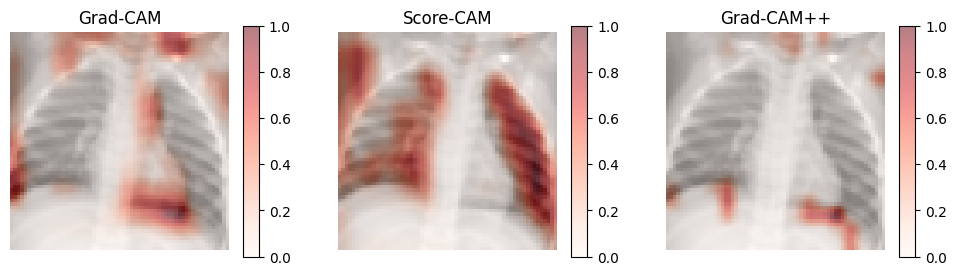

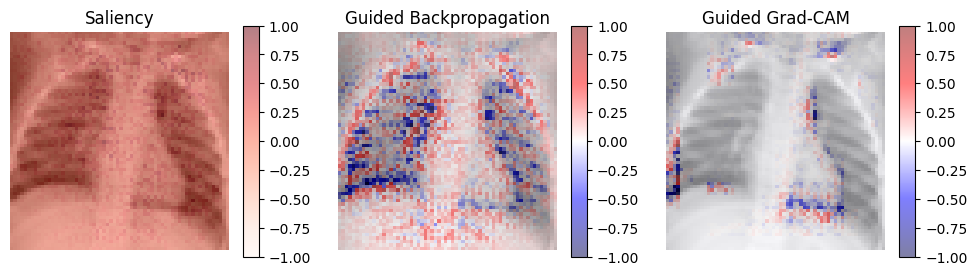

True Class: 0 Class Probabilities: [0.952089   0.04791099]


100%|██████████| 4/4 [00:00<00:00, 253.98it/s]


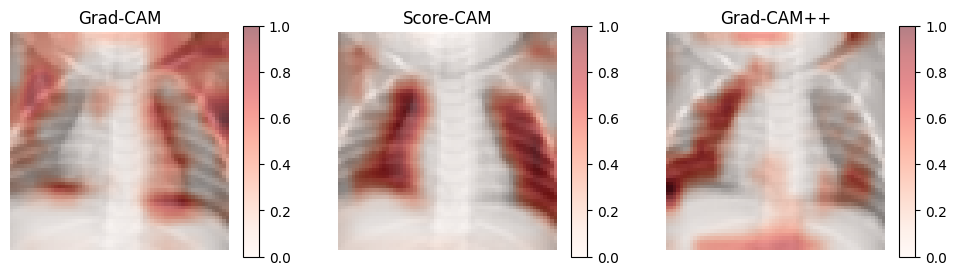

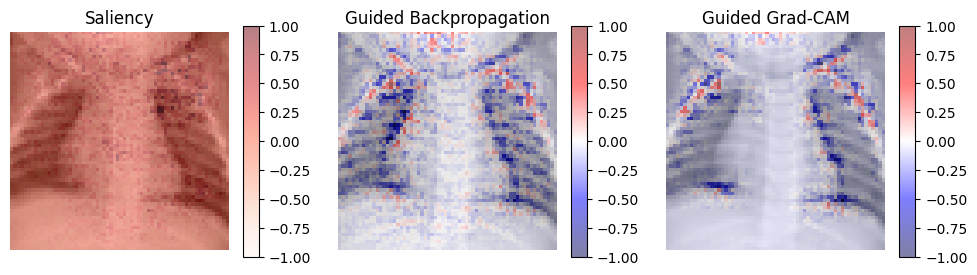

True Class: 0 Class Probabilities: [9.9998963e-01 1.0382465e-05]


100%|██████████| 4/4 [00:00<00:00, 242.96it/s]


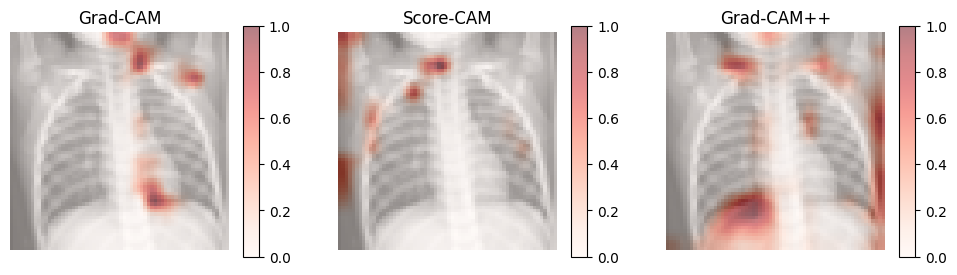

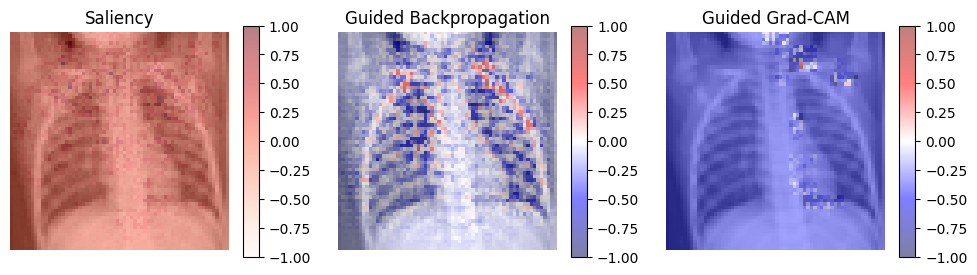

True Class: 0 Class Probabilities: [0.9846186  0.01538134]


100%|██████████| 4/4 [00:00<00:00, 237.23it/s]


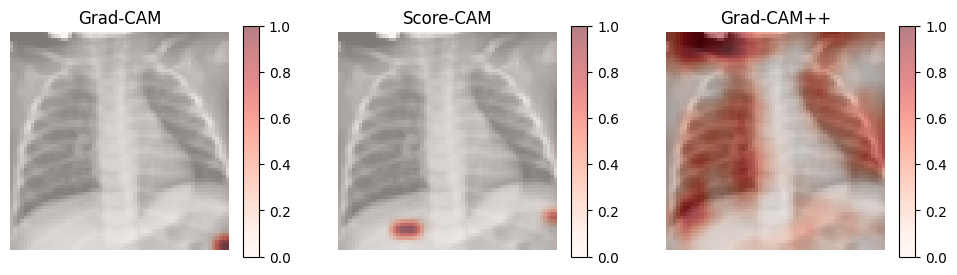

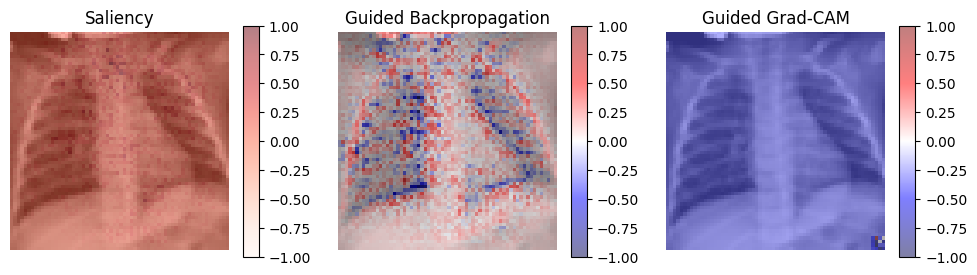

True Class: 0 Class Probabilities: [0.99455357 0.00544642]


100%|██████████| 4/4 [00:00<00:00, 246.50it/s]


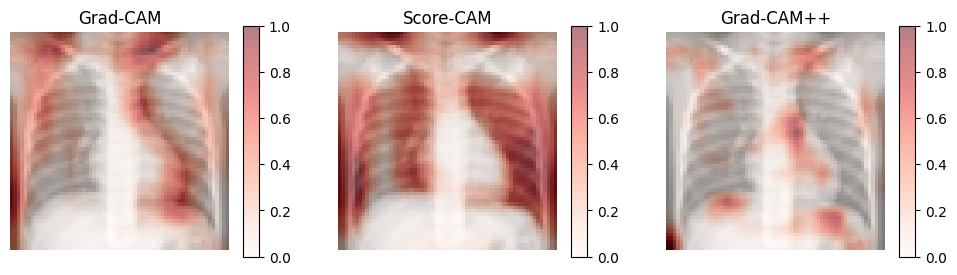

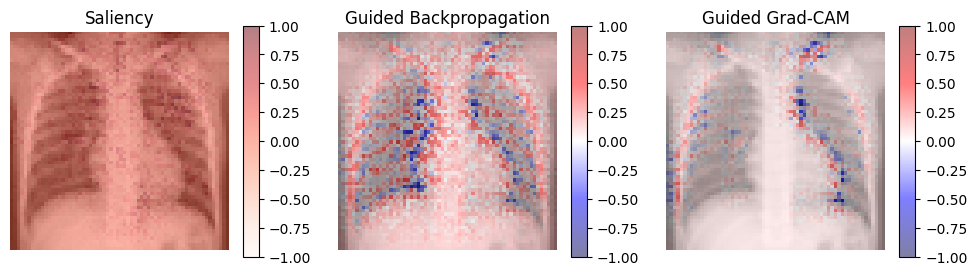

In [161]:
attribution_plots(N=5,target_class=0,td=0.5,model=model,data=test_loader)    

## Latent Space Features

In [162]:
import numpy as np
import monai
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [163]:
def extract_feats(pre_model,dataloader,inter_layer):

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    for name, layer in pre_model.named_modules():
        layer.register_forward_hook(get_activation(name))

    feats=[]
    for batch in dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        pre_output=pre_model(inputs)

        feats.append(activation[inter_layer].cpu().numpy().ravel())#[:400])	
    feats=np.asarray(feats)
    return feats


def make_2_plots(X1,X2,legend_elements,colors):
    # plot two main components
    plt.scatter(X1[0],X1[1], c=colors)
    plt.title("2 main principal components")
    plt.legend(handles=legend_elements)
    plt.show()

    plt.scatter(X2[0],X2[1], c=colors)
    plt.title("t-SNE")
    plt.legend(handles=legend_elements)
    plt.show()

def plot_latent_space(args,model,target_layer_name,dataloader,do_both=True):

    # extract latent space features
    feats=extract_feats(model,dataloader,target_layer_name)

    print(feats.shape)

    # use PCA to reduce number of features
    pca=PCA(n_components=50)
    new_feats=pca.fit_transform(feats)
    print(new_feats.shape)

    #plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
    #plt.show()


    # use t-SNE to viszualize in 2d
    embedded = TSNE().fit_transform(new_feats)
    print(embedded.shape)

    preds, y_preds, y_true = eval_model(args, model, dataloader, False)

    labels=["Predicted 0","Predicted 1"]
    colors=["b" if y_preds[i]==0 else "r" for i in range(len(y_preds))]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0], markerfacecolor='b', markersize=15), 
        Line2D([0], [0], marker='o', color='w', label=labels[1], markerfacecolor='r', markersize=15)]

    make_2_plots([new_feats[:, 0], new_feats[:, 1]],[embedded[:, 0], embedded[:, 1]],legend_elements,colors)
    
    if do_both:
        labels=["Correct 0", "Correct 1", "Incorrect 0", "Incorrect 1"]
        #colors=["b" for i in range(len(y_preds)) if (y_preds[i]==0 and y_true[i]==0) else "g" if (y_preds[i]==1 and y_true[i]==1) else "r" if (y_preds[i]==0 and y_true[i]==1) else "orange" if (y_preds[i]==1 and y_true[i]==0)]
        combinations = [(0,0),(0,1),(1,0),(1,1)]
        cs = ["b","r","orange","g"]
        colors=[cs[combinations.index((y_preds[i],np.around(y_true[i])))] for i in range(len(y_preds))]

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0], markerfacecolor='b', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[1], markerfacecolor='g', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[2], markerfacecolor='r', markersize=15), 
            Line2D([0], [0], marker='o', color='w', label=labels[3], markerfacecolor='orange', markersize=15)]            
        make_2_plots([new_feats[:, 0], new_feats[:, 1]],[embedded[:, 0], embedded[:, 1]],legend_elements,colors)

In [164]:
# only look at subset with confident decision

# select a subset containing N correctly predicted samples (over threshold cd) of each class
cd=0.6
N=400   
confident_data=[]
n_0,n_1=0,0
p_n=[]
for inputs, labels in test_loader:
    if labels==0 and n_0<N: 
        normed=torch.nn.functional.softmax(model(inputs.to(device)), dim=-1).detach().cpu().numpy()[0]
        if normed[int(labels)]>=cd:
            confident_data.append((inputs.cpu(),labels.cpu()))
            p_n.append(normed[int(labels)])
            n_0+=1
    if labels==1 and n_1<N: 
        normed=torch.nn.functional.softmax(model(inputs.to(device)), dim=-1).detach().cpu().numpy()[0]
        if normed[int(labels)]>=cd:
            confident_data.append((inputs.cpu(),labels.cpu()))
            p_n.append(normed[int(labels)])
            n_1+=1
    if n_0>=N and n_1>=N: break
            
print(len(p_n),n_0,n_1)

496 107 389


(496, 512)
(496, 50)
(496, 2)


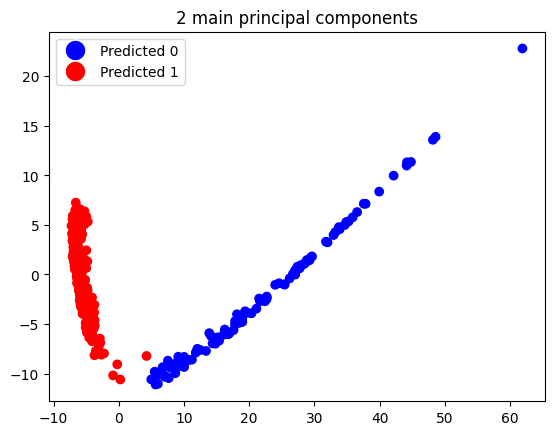

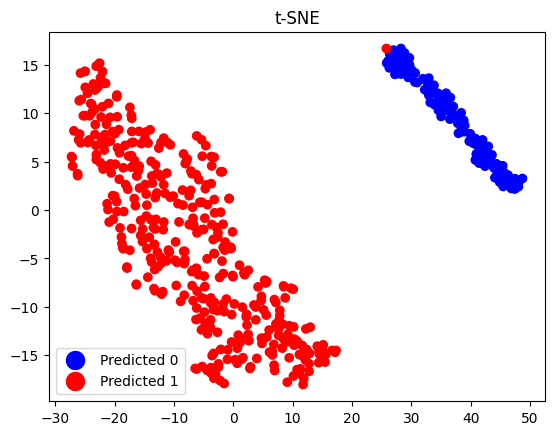

In [166]:
plot_latent_space(None,model,target_layer_name,confident_data,False)